In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from poker_utils.constants import HANDS_DICT
from poker_utils.model import analyze_embeddings, save_model_and_embeddings, plot_train_loss, prob_embeddings

In [2]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")

In [3]:
equity_cols = [
    'tot_win_perc', 'high_card_win_perc', 'one_pair_win_perc', 
    'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential'
    ]

blocker_cols = [
    'prem_blocker_score_norm', 'block_aa_score', 'block_kk_score',
]

base_cols = [
    # 'suited', 'pair', 'ace', 'broadway_score', 
    # 'low_pair', 'medium_pair', 'high_pair', 
    # 'suited_broadway_score', 
    # 'connector', 'one_gap', 'two_gap', 
    # 'suited_connector', 'suited_one_gap', 'suited_two_gap',
    # 'connectedness_score', 'rank_diff_score', 'high_card_score',
    # 'low_card_score', 'suited_connected_score'
    ]

In [4]:
full_data = pd.concat(
    [base_data[base_cols], 
     blocker_data[blocker_cols], 
     equity_data[equity_cols], 
     ev_data], axis=1)

In [5]:
handhand_data = pd.read_csv("data/processed/handhand_equity.csv")
handhand_data['equity_diff'] = handhand_data.hand1_equity - handhand_data.hand2_equity
handhand_data['equity_bin'] = pd.cut(handhand_data['equity_diff'], bins=10, labels=False)

In [6]:
class EquityDiffDataset:
    def __init__(self, feature_data, handhand_equity, train=None):
        self.train = train
        self.hands = feature_data.index
        self.feature_data = feature_data
        if train is not None:
            train_data, val_data = train_test_split(
                handhand_equity,
                test_size=0.3, 
                stratify=handhand_equity['equity_bin'],
                random_state=29
                )

            if train == True: 
                self.data = train_data
            elif train == False:
                self.data = val_data
        else:
            self.data = feature_data
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if self.train is not None:
            row = self.data.iloc[idx]
            hand1 = row['hand1']
            hand2 = row['hand2']
            hand1_features = self.feature_data.loc[hand1].to_numpy()
            hand2_features = self.feature_data.loc[hand2].to_numpy()
            equity_diff = row['equity_diff']
            if equity_diff > 0:
                rank = 1
            else:
                rank = -1
            return (
                torch.tensor(hand1_features, dtype=torch.float32),
                torch.tensor(hand2_features, dtype=torch.float32),
                torch.tensor(equity_diff, dtype=torch.float32),
                torch.tensor(rank, dtype=torch.float32),
            )
        else:
            return torch.tensor(self.data.iloc[idx].to_numpy(), dtype=torch.float32)
        

In [7]:
train_dataset = EquityDiffDataset(full_data, handhand_data, train=True)
val_dataset = EquityDiffDataset(full_data, handhand_data, train=False)
full_dataset = EquityDiffDataset(full_data, handhand_data)

In [8]:
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=128)
valloader = DataLoader(val_dataset, shuffle=False, batch_size=128)
fullloader = DataLoader(full_dataset, shuffle=False, batch_size=len(full_dataset))

In [9]:
class EquityDiffModel(nn.Module):
    def __init__(self, input_size=90, embedding_dim=8, hidden_dim=64):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, embedding_dim)
        )
        
        self.comparison = nn.Sequential(
            nn.Linear(embedding_dim*2, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim//2, 1)
        )
    
    def forward(self, hand1, hand2):
        emb1 = self.encoder(hand1)
        emb1 = F.normalize(emb1, p=2, dim=1)
        emb2 = self.encoder(hand2)
        emb2 = F.normalize(emb2, p=2, dim=1)
        combined = torch.cat([emb1, emb2], dim=1)
        equity_diff = self.comparison(combined)
        return emb1, emb2, equity_diff

In [10]:
def train_equity_model(model, trainloader,  valloader,  equity_loss_func,  optimizer,  epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        tot_train_loss = 0
        for hand1_feat, hand2_feat, equity_diff, rank in trainloader:
            optimizer.zero_grad()
            equity_diff = equity_diff.unsqueeze(1)
            emb1, emb2, pred_diff = model(hand1_feat, hand2_feat)
            equity_loss = equity_loss_func(pred_diff, equity_diff)
            
            equity_loss.backward()
            optimizer.step()
            tot_train_loss += equity_loss.item()
        avg_train_loss = tot_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        model.eval()
        tot_val_loss = 0
        with torch.no_grad():
            for hand1_feat, hand2_feat, equity_diff, rank in valloader:
                equity_diff = equity_diff.unsqueeze(1)
                emb1, emb2, pred_diff = model(hand1_feat, hand2_feat)
                equity_loss = equity_loss_func(pred_diff, equity_diff)
                tot_val_loss += equity_loss.item()
            avg_val_loss = tot_val_loss / len(trainloader)
            val_losses.append(avg_val_loss)
            
        if epoch % (epochs//5) == 0 or epoch == epochs-1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    return train_losses, val_losses

In [11]:

equity_model = EquityDiffModel(input_size=71, embedding_dim=16)
optimizer = torch.optim.Adam(params=equity_model.parameters(), lr=0.001)
equity_loss_func = nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=3
# )


Epoch 1/15, Train Loss: 0.0412, Val Loss: 0.0132
Epoch 4/15, Train Loss: 0.0119, Val Loss: 0.0083
Epoch 7/15, Train Loss: 0.0097, Val Loss: 0.0057
Epoch 10/15, Train Loss: 0.0087, Val Loss: 0.0057
Epoch 13/15, Train Loss: 0.0082, Val Loss: 0.0050
Epoch 15/15, Train Loss: 0.0076, Val Loss: 0.0059


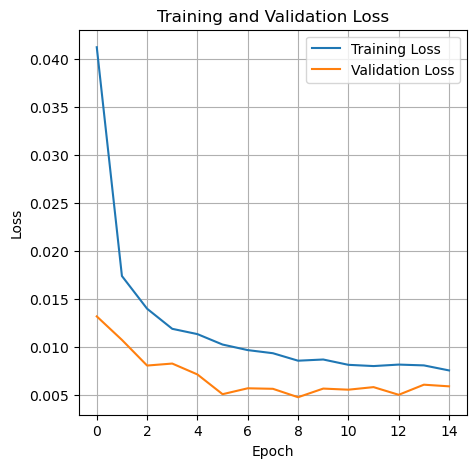

In [12]:
equity_train_losses, equity_val_losses = train_equity_model(
    equity_model, 
    trainloader, 
    valloader, 
    equity_loss_func, 
    optimizer,
    # scheduler
    epochs=15
    )

plot_train_loss(equity_train_losses, equity_val_losses)


In [13]:
all_hands = next(iter(fullloader))
equity_model.eval()
with torch.no_grad():
    equity_emb = equity_model.encoder(all_hands)
    equity_emb = F.normalize(equity_emb, p=2, dim=1)

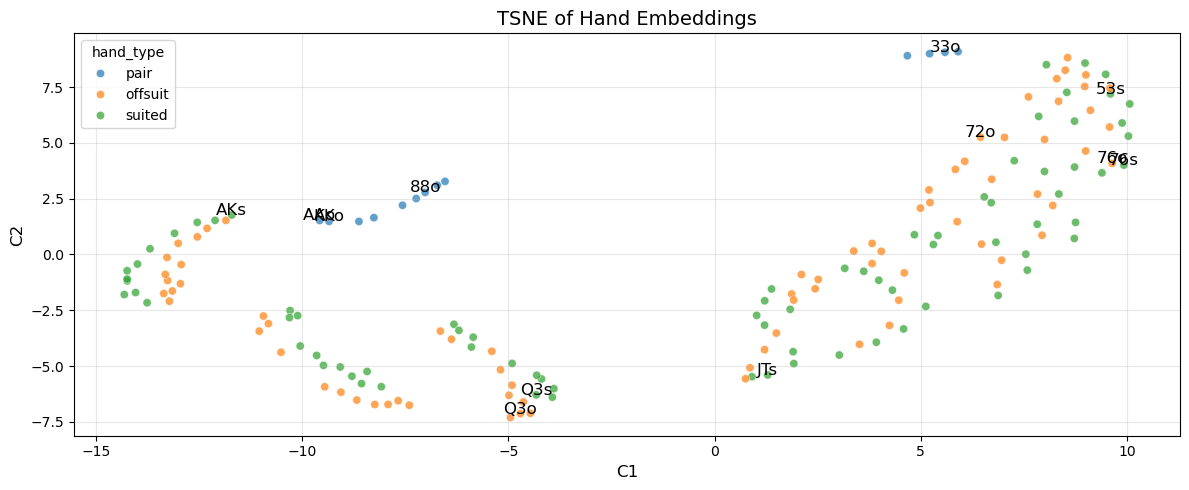

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9611)  QQo (0.7651)  AKs (0.6871)  Q4o (-0.5495)   
1   KKo  AAo (0.9611)  QQo (0.8859)  JJo (0.7500)  T3o (-0.4790)   
2   72o  73o (0.9806)  82o (0.9677)  83o (0.9519)  JJo (-0.6515)   
3   76s  76o (0.9819)  75s (0.9760)  65s (0.9602)  K6s (-0.8060)   
4   76o  76s (0.9819)  75s (0.9796)  75o (0.9700)  K9s (-0.7662)   
5   Q3s  Q5o (0.9875)  Q6o (0.9842)  Q2s (0.9804)  54s (-0.6750)   
6   Q3o  Q4o (0.9987)  Q2o (0.9916)  Q5o (0.9823)  AQs (-0.6556)   
7   88o  99o (0.9562)  77o (0.9454)  66o (0.8632)  62o (-0.4130)   
8   JTs  J9s (0.9905)  JTo (0.9772)  J9o (0.9713)  44o (-0.6997)   
9   33o  44o (0.9460)  22o (0.9433)  55o (0.7917)  JTo (-0.7043)   
10  AKs  AKo (0.9687)  AQs (0.9489)  AJs (0.8875)  J4o (-0.7157)   
11  53s  43s (0.9818)  54s (0.9779)  52s (0.9681)  Q9s (-0.7124)   

         bottom_2       bottom_3  
0   J4o (-0.5635)  J2o (-0.5697)  
1   J2o (-0.4939)  72o (-0.4956)  
2   TTo (-

In [14]:
similarity_df = analyze_embeddings(
    equity_emb, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

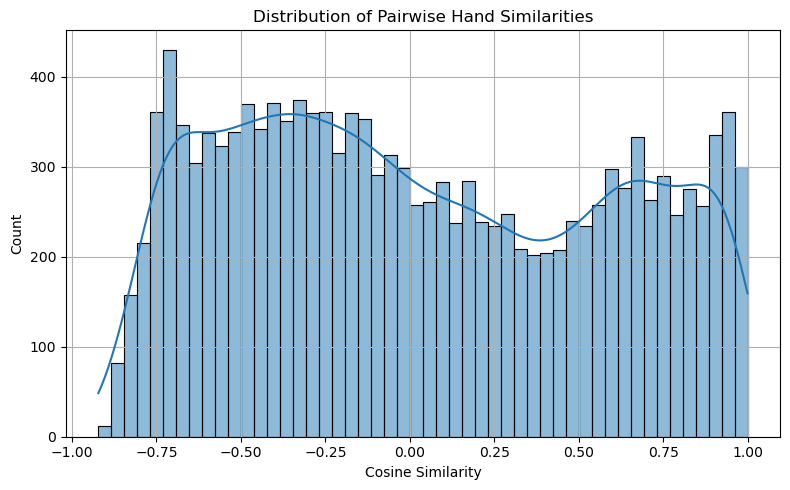

In [15]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)

all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
prob_data = prob_embeddings(equity_emb, base_data)

In [23]:
prob_data[prob_data.attribute == 'suited']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
0,suited,0,0.994083,1.000000,0.989011,0.994475,0.538462
1,suited,1,0.994083,0.987342,1.000000,0.993631,0.461538


In [17]:
prob_data[prob_data.attribute == 'connectedness']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
2,connectedness,0,0.597633,1.000000,1.000000,1.000000,0.076923
3,connectedness,1,0.597633,0.666667,0.846154,0.745763,0.153846
4,connectedness,2,0.597633,0.578947,0.458333,0.511628,0.142012
5,connectedness,3,0.597633,0.619048,0.590909,0.604651,0.130178
6,connectedness,4,0.597633,0.812500,0.650000,0.722222,0.118343
7,connectedness,5,0.597633,0.666667,0.777778,0.717949,0.106509
8,connectedness,6,0.597633,0.421053,0.500000,0.457143,0.094675
9,connectedness,7,0.597633,0.272727,0.300000,0.285714,0.059172
10,connectedness,8,0.597633,0.400000,0.250000,0.307692,0.047337
11,connectedness,9,0.597633,0.200000,0.166667,0.181818,0.035503


In [18]:
prob_data[prob_data.attribute == 'pair']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
14,pair,0,1.0,1.0,1.0,1.0,0.923077
15,pair,1,1.0,1.0,1.0,1.0,0.076923


In [19]:
prob_data[prob_data.attribute == 'broadway']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
60,broadway,0,0.994083,1.000000,1.00,1.000000,0.378698
61,broadway,1,0.994083,0.987654,1.00,0.993789,0.473373
62,broadway,2,0.994083,1.000000,0.96,0.979592,0.147929


In [20]:
prob_data[prob_data.attribute == 'suited_connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
78,suited_connector,0,0.95858,0.957055,1.000000,0.978056,0.923077
79,suited_connector,1,0.95858,1.000000,0.461538,0.631579,0.076923


In [21]:
prob_data[prob_data.attribute == 'connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
72,connector,0,0.911243,0.932432,0.965035,0.948454,0.846154
73,connector,1,0.911243,0.761905,0.615385,0.680851,0.153846


In [22]:
prob_data[prob_data.attribute == 'one_gap']

,attribute,class,accuracy,precision,recall,f1_score,support_frac
74,one_gap,0,0.857988,0.857988,1.0,0.923567,0.857988
75,one_gap,1,0.857988,0.000000,0.0,0.000000,0.142012


In [ ]:
# save_model_and_embeddings(
#     equity_emb,
#     'preflop_embeddings_equitydiff',
#     equity_model,
#     "preflop_equitydiff_encoder_weights"
#     )